# JHU covid-19 data analysis
Create log plots of cases and deaths per country, inspired by:  https://www.ft.com/coronavirus-latest 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  
import numpy as np
from datetime import timedelta
from matplotlib.dates import date2num       #-->Update 
import JHUprocessing as jp
from matplotlib.colors import ListedColormap

# general parameters

In [2]:
 # figure size
full_w = (12,7)
half_w = (6,4) 

cols = np.array([[213,62,79],
[244,109,67],
[253,174,97],
[254,224,139], 
[171,221,164], 
[50,136,189]]) /255 
cols = np.flipud(cols)
cmap = ListedColormap(cols) 

threshold_cases = 100
threshold_deaths = 25

# ticks 
tick_list = [1e2,2e2,5e2,1e3,2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6,]
tick_label_list = [100,200,500, 1000,2000,5000, '10k','20k','50k', '100k','200k','500k','1m','2m','5m']

# doubling rate average period 
averaging_period = 3

# china artificial days since day 0, next + china_ad
china_add = 6

# annotation properties of figures
bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5)

notable_countries = ['US','Italy','Spain','China', 'France','Germany','Iran',
                     'United Kingdom','Switzerland','Turkey','Netherlands','Austria',
                        'Korea, South','Brazil'  ,'Sweden','Japan',
                        'Dominican Republic', 'Russia','Ukraine' ]
bin_array = np.array( [-1, 2.**(1./20), 2.**(1./15), 2.**(1./10), 2.**(1./7), 2.**(1./5)  ,np.inf ]) 

dot_col = np.ones((3))*0.8 
emph_col = [0.5,0.5,0.5]  
goal_col = "r"
dot_alpha = 1 

# import and merge data

In [3]:
path = r'D:\Code_projects\Covid19_analysis\COVID-19\csse_covid_19_data\csse_covid_19_time_series'
file_list = ['\\time_series_covid19_confirmed_global.csv',
         '\\time_series_covid19_deaths_global.csv',
         '\\time_series_covid19_recovered_global.csv'] 

df_country = jp.merge_countrydf(path, file_list) 

# remove diamond princess
bool_other = df_country['Country/Region'].str.contains( 'Princess' , regex=False)
df_country.reset_index(drop=True, inplace=True)

# add column with day since 100 cases 

In [4]:
df_country['Delta C'] =  jp.days_since_threshold( df_country['Date'],
                                df_country['Confirmed'],
                                df_country['Country/Region'] , 
                                threshold_cases) 

df_country['Delta D'] = jp.days_since_threshold( df_country['Date'],
                                df_country['Death'],
                                df_country['Country/Region'] , 
                                threshold_deaths)

# correct china days for plotting 

In [5]:
bool_nochina = df_country['Country/Region']!= 'China'
xCmax = df_country.loc[bool_nochina,'Delta C'].max()
xDmax = df_country.loc[bool_nochina,'Delta D'].max()
 
last_day = df_country['Date'].unique()[-1] 

bool_cases= df_country['Delta C'] > (xCmax+china_add)
bool_deaths = df_country['Delta D'] > (xDmax+china_add)
bool_china = df_country['Country/Region'] == 'China'

df_country.loc[bool_cases & bool_china,'Delta C'] = xCmax+ china_add
df_country.loc[bool_deaths & bool_china,'Delta D'] = xDmax+ china_add

# Find doubling rate

In [6]:
df_country['ratio'] = jp.get_exponential_ratio( df_country['Date'], 
                                            df_country['Confirmed'],
                                            df_country['Country/Region'], 
                                            averaging_period )   
df_country['doubling'] = pd.cut( df_country['ratio'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )
 
df_country['ratioD'] = jp.get_exponential_ratio( df_country['Date'], 
                                            df_country['Death'],
                                            df_country['Country/Region'], 
                                            averaging_period )  
df_country['doublingD'] = pd.cut( df_country['ratioD'],   bin_array ,labels=range(len(bin_array)-1) , include_lowest=True )

# Plot countries

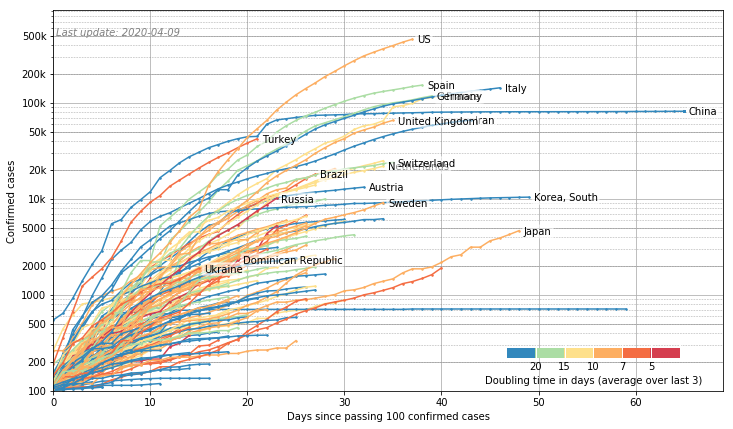

In [7]:
try_bool = df_country.groupby('Country/Region').max()['Delta C'] > 0 
threshold_countries = try_bool.index[try_bool].tolist()
 
fig, ax = plt.subplots(1,1 ,figsize= full_w ) 
for country in threshold_countries:
    bool_country = df_country['Country/Region'] == country 
    df_pl = df_country[bool_country] 
    doubling_category = df_pl['doubling'].iloc[0]
    pl1 = ax.plot( df_pl['Delta C' ],  df_pl['Confirmed'],
            '.-' ,ms=3,lw=1.5, label=country,
               color = cols[doubling_category])
      
    if country in notable_countries:
        y = df_pl['Confirmed'].iloc[-1]*0.98
        x = df_pl['Delta C'].iloc[-1] + 0.5         
        t = ax.text(x,y,country, ha="left", va="center" ,  bbox=bbox_props)
         
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)  

ymax = df_country['Confirmed'].max()

ax.yaxis.set_ticks( tick_list )
ax.yaxis.set_ticklabels( tick_label_list)

ax.set_xlim([0,xCmax+10])
ax.set_ylim([100,ymax*2])

ax.set_xlabel("Days since passing "+ str(threshold_cases) + " confirmed cases") 
ax.set_ylabel("Confirmed cases") 

ax.annotate('Last update: '+str( df_country['Date'].iloc[-1]), 
            [.3,round(ymax,5)*1.1], color=[.5,.5,.5], style='italic')

xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal') 

cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels( ['20','15','10','7','5']) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False) 
cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')

# # # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_caseslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            ) 

# plot deaths 

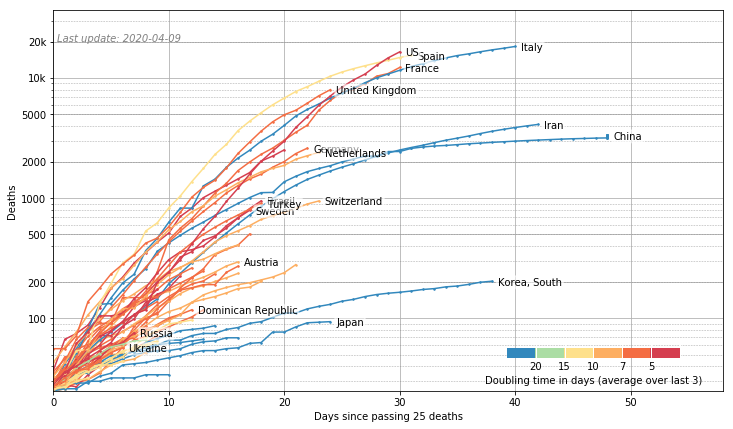

In [8]:
fig, ax = plt.subplots(1,1 ,figsize= full_w )


cmap = plt.cm.jet  # define the colormap
for country in threshold_countries:
    bool_country = df_country['Country/Region'] == country 
    df_pl = df_country[bool_country] 
    doubling_category = df_pl['doublingD'].iloc[0]
    pl1 = ax.plot( df_pl['Delta D' ],  df_pl['Death']  ,
            '.-' ,ms=3,lw=1.5, label=country,
               color = cols[doubling_category])
      
    if country in notable_countries:  
        y = df_pl['Death'].iloc[-1]*0.98
        x = df_pl['Delta D'].iloc[-1] + 0.5          
        t = ax.text(x,y,country, ha="left", va="center" ,  bbox=bbox_props)
         
ax.set_yscale('log') 
ax.grid(True,which="major", linestyle='-')  
ax.grid(True,which="minor", linestyle=':', color=[.5,.5,.5],linewidth=0.6)   
 
ax.yaxis.set_ticks( tick_list )
ax.yaxis.set_ticklabels( tick_label_list)

xDmax = df_country['Delta D'].max()
yDmax = df_country['Death'].max()
ax.set_xlim([0,xDmax+10])
ax.set_ylim([25,yDmax*2])
  
ax.set_xlabel("Days since passing " + str(threshold_deaths)+ " deaths") 
ax.set_ylabel("Deaths") 

ax.annotate('Last update: '+str( df_country['Date'].iloc[-1]), 
            [.3,round(yDmax,5)*1.1], color=[.5,.5,.5], style='italic')
 
cmap = ListedColormap(cols)
xy = []
sc = plt.scatter(xy, xy, c=xy, vmin=0, vmax=1, cmap=cmap)
cax = fig.add_axes([0.65, 0.19, 0.2, 0.02])
cb = plt.colorbar(sc, cax = cax, orientation='horizontal')  
cb.set_ticks(np.linspace(1/6,1,6)) 
cb.set_ticklabels( ['20','15','10','7','5']) 
cb.set_label('Doubling time in days (average over last 3)')
cb.outline.set_visible(False)

cb.ax.tick_params(which='major', length=15, width=1, direction='in',color='w')


# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_deathslog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

# plot case highlights

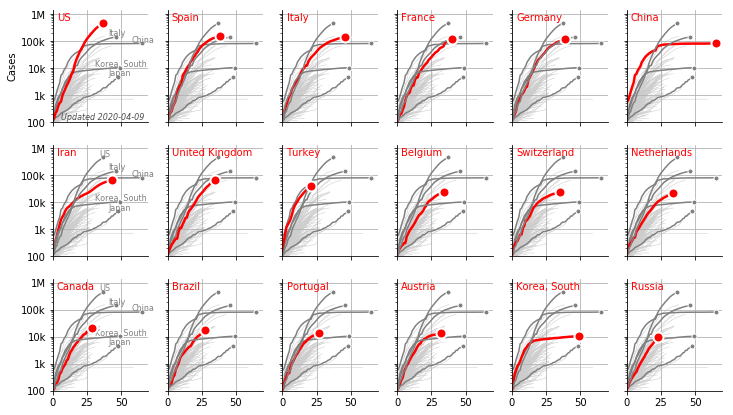

In [9]:
# sort countries by confirmed cases on last date
bool_last = df_country['Date'] == df_country['Date'].max()
sorted_countries = df_country[bool_last].sort_values(by=['Confirmed'], ascending=False )     
sorted_names = sorted_countries['Country/Region'].tolist() 

country_highlight = ['US','Japan','China','Italy' ,'Korea, South' ] 

dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w )
 
for i, (ax_1, goal_country) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])):  
    ax_1 = jp.plot_highlight(ax_1, goal_country, df_country['Delta C'],
                                            df_country['Confirmed'],
                                            df_country['Country/Region'],
                                            country_highlight)
    ax_1 .grid(True )   
    
    if np.mod(i,dx) ==0:
        for country in threshold_countries:
            if (country in country_highlight) &( country not in goal_country):
                bool_country = df_country['Country/Region'] == country 
                df_pl = df_country[bool_country] 

                y = df_pl['Confirmed'].iloc[-1]*1.1
                x = df_pl['Delta C'].iloc[-1] + 1 
                ax_1.annotate( country ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
         
    xCmax = df_country['Delta C'].max() 
    yCmax = df_country['Confirmed'].max()
        
    ax_1.set_xlim([0,xCmax+5])
    ax_1.set_ylim([100,yCmax*3])
      
    ax_1.spines['top'].set_visible(False)
    ax_1.spines['right'].set_visible(False)
    
ax[0,0].set_ylabel('Cases') 
ax[0,0].annotate('Updated '+str( df_country['Date'].iloc[-1]), 
            [6, 120], color=[.3,.3,.3], style='italic',fontsize=8)
 
# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_casesHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  

 # plot death highlights

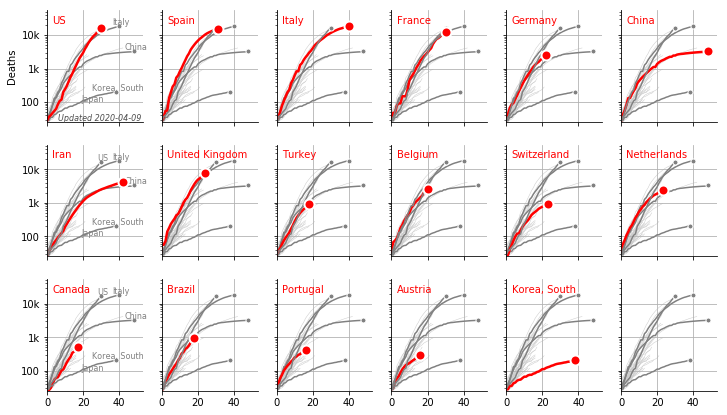

In [10]:
country_highlight = ['US','Japan','China','Italy' ,'Korea, South' ]
   
dy = 3
dx = 6
fig, ax = plt.subplots( dy,dx ,figsize=full_w )
 
for i, (ax_1, goal_country) in enumerate( zip(ax.reshape(-1), sorted_names[:(dy*dx)])): 
#     ax_1 = plot_highlight(ax_1, goal_country, df_country)  
    
    ax_1 = jp.plot_highlight(ax_1, goal_country, df_country['Delta D'],
                                            df_country['Death'],
                                            df_country['Country/Region'],
                                            country_highlight) 
    ax_1 .grid(True )  
    
    if np.mod(i,dx) ==0:
        for country in threshold_countries:
            if (country in country_highlight) &( country not in goal_country):
                bool_country = df_country['Country/Region'] == country 
                df_pl = df_country[bool_country] 

                y = df_pl['Death'].iloc[-1]*1.1
                x = df_pl['Delta D'].iloc[-1] + 1 
                ax_1.annotate( country ,[x,y], color=emph_col, fontsize = 8, ha='center')
    else: 
        ax_1.axes.get_yaxis().set_ticklabels([])
    if i< (dy-1)*dx:
        ax_1.axes.get_xaxis().set_ticklabels([])
         
    xDmax = df_country['Delta D'].max() 
    yDmax = df_country['Death'].max()
        
    ax_1.set_xlim([0,xDmax+5])
    ax_1.set_ylim([25,yDmax*3])
     
ax[0,0].set_ylabel('Deaths')

ax[0,0].annotate('Updated '+str( df_country['Date'].iloc[-1]), 
            [6, 28], color=[.3,.3,.3], style='italic',fontsize=8)

# # # # # save fig  -----------------------------------------------------------------------
fig_name= 'covid_country_deathsHighlightLog'
save_fig = True
if save_fig: 
    plt.savefig('./figs/' + fig_name + '.png',
            format='png', dpi=300,
            transparent=  True,             
            bbox_inches = 'tight', pad_inches = 0,
            )  